In [1]:
import torch
import torch.nn as nn
from typing import Tuple, Union, Optional, List
# import torchvision
# import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import math


In [2]:
class AverageMeter():
    def __init__(self):
        self.num = 0
        self.tot = 0

    def update(self, val: float, sz: float):
        self.num += val*sz
        self.tot += sz

    def calculate(self) -> float:
        return self.num/self.tot

# Base Transformer Implementation

In [3]:
class AttentionHead(nn.Module):
  """
  Adapted from 6.7920 Fall 2024 HW3
  """
  def __init__(self, dim: int, n_hidden: int, relation_aware=False):
      # dim: the dimension of the input
      # n_hidden: the dimension of the keys, queries, and values

      super().__init__()

      self.W_K = nn.Linear(dim, n_hidden) # W_K weight matrix
      self.W_Q = nn.Linear(dim, n_hidden) # W_Q weight matrix
      self.W_V = nn.Linear(dim, n_hidden) # W_V weight matrix
      self.n_hidden = n_hidden

  def forward(self, x: torch.Tensor, attn_mask: Optional[torch.Tensor], relation_aware: Optional[bool], rel_K: Optional[torch.Tensor], rel_V: Optional[torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
      # x                the inputs. shape: (B x T x dim)
      # attn_mask        an attention mask. If None, ignore. If not None, then mask[b, i, j]
      #                  contains 1 if (in batch b) token i should attend on token j and 0
      #                  otherwise. shape: (B x T x T)
      # rel_k and rel_V  the relative time representations, if relation_aware is False then ingore
      #                  shape: (B x T x T x n_hidden)
      #
      # Outputs:
      # attn_output      the output of performing self-attention on x. shape: (Batch x Num_tokens x n_hidden)
      # alpha            the attention weights (after softmax). shape: (B x T x T)
      #

      out, alpha = None, None
      # TODO: Compute self attention on x.
      #       (1) First project x to the query Q, key K, value V.
      #       (2) Then compute the attention weights alpha as:
      #                  alpha = softmax(QK^T/sqrt(n_hidden))
      #           Make sure to take into account attn_mask such that token i does not attend on token
      #           j if attn_mask[b, i, j] == 0. (Hint, in such a case, what value should you set the weight
      #           to before the softmax so that after the softmax the value is 0?)
      #       (3) The output is a linear combination of the values (weighted by the alphas):
      #                  out = alpha V
      #       (4) return the output and the alpha after the softmax

      # ======= Answer START ========
      Q = self.W_Q(x) # Shape: B x T x n_hidden
      K = self.W_K(x)
      V = self.W_V(x)

      alpha = (Q @ K.transpose(1, 2)) / np.sqrt(self.n_hidden) # Shape: B x T x T

      if relation_aware:
        alpha += torch.einsum('btd,btid->bti', Q, rel_K) # Shape: B x T x T

      if attn_mask is not None:
        alpha[attn_mask == 0] = -float('inf')

      # alpha = alpha.flatten(start_dim=1).softmax(dim=1).reshape(alpha.shape)
      alpha = alpha.softmax(dim=-1)
      # B x T^2 -> B x T

      attn_output = alpha @ V # Shape: B x T x n_hidden
      if relation_aware:
        # attn_output += alpha * rel_V # Shape: B x T x n_hidden
        attn_output += torch.einsum('bti,btid->btd', alpha, rel_V) # Shape: B x T x n_hidden
      # ======= Answer  END ========

      return attn_output#, alpha


In [4]:
class MultiHeadedAttention(nn.Module):
    """
    Adapted from 6.7920 Fall 2024 HW3
    """
    def __init__(self, dim: int, n_hidden: int, num_heads: int):
        # dim: the dimension of the input
        # n_hidden: the hidden dimenstion for the attention layer
        # num_heads: the number of attention heads
        super().__init__()

        # TODO: set up your parameters for multi-head attention. You should initialize
        #       num_heads attention heads (see nn.ModuleList) as well as a linear layer
        #       that projects the concatenated outputs of each head into dim
        #       (what size should this linear layer be?)

        # ======= Answer START ========
        self.attn_heads = nn.ModuleList([AttentionHead(dim, n_hidden) for _ in range(num_heads)])
        self.linear = nn.Linear(num_heads * n_hidden, dim)
        # ======= Answer  END ========

    def forward(self, x: torch.Tensor, attn_mask: Optional[torch.Tensor], relation_aware=False, rel_K=None, rel_V=None) -> Tuple[torch.Tensor, torch.Tensor]:
        # x                the inputs. shape: (B x T x dim)
        # attn_mask        an attention mask. If None, ignore. If not None, then mask[b, i, j]
        #                  contains 1 if (in batch b) token i should attend on token j and 0
        #                  otherwise. shape: (B x T x T)
        #
        # Outputs:
        # attn_output      the output of performing multi-headed self-attention on x.
        #                  shape: (B x T x dim)
        # attn_alphas      the attention weights of each of the attention heads.
        #                  shape: (B x Num_heads x T x T)

        attn_output, attn_alphas = None, None

        # TODO: Compute multi-headed attention. Loop through each of your attention heads
        #       and collect the outputs. Concatenate them together along the hidden dimension,
        #       and then project them back into the output dimension (dim). Return both
        #       the final attention outputs as well as the alphas from each head.

        # ======= Answer START ========
        B, T, _ = x.shape
        attn_outputs = torch.zeros((B, T, 0)).to(x.device) # device=x.device)
        attn_alphas = torch.zeros((B, 0, T, T)).to(x.device) # device=x.device)
        for head in self.attn_heads:
          # attn_output, attn_alpha = head(x, attn_mask, relation_aware, rel_K, rel_V)
          attn_output = head(x, attn_mask, relation_aware, rel_K, rel_V)
          attn_outputs = torch.cat((attn_outputs, attn_output), dim=-1) # concatenate the (B, T, n_hidden) tensor along last dim
          # attn_alphas = torch.cat((attn_alphas, attn_alpha.unsqueeze(1)), dim=1) # concat (B, 1, T, T) tensor along dimension 1

        attn_output = self.linear(attn_outputs) # linear layer on a (B, T, n_hidden*num_heads) tensor into (B, T, n_hidden)
        # ======= Answer END ========
        return attn_output#, attn_alphas

In [5]:
# these are already implemented for you!

class FFN(nn.Module):
    def __init__(self, dim: int, n_hidden: int):
        # dim       the dimension of the input
        # n_hidden  the width of the linear layer

        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, n_hidden),
            nn.GELU(),
            nn.Linear(n_hidden, dim),
        )

    def forward(self, x: torch.Tensor)-> torch.Tensor:
        # x         the input. shape: (B x T x dim)

        # Outputs:
        # out       the output of the feed-forward network: (B x T x dim)
        return self.net(x)

class AttentionResidual(nn.Module):
    def __init__(self, dim: int, attn_dim: int, mlp_dim: int, num_heads: int):
        # dim       the dimension of the input
        # attn_dim  the hidden dimension of the attention layer
        # mlp_dim   the hidden layer of the FFN
        # num_heads the number of heads in the attention layer
        super().__init__()
        self.attn = MultiHeadedAttention(dim, attn_dim, num_heads)
        self.ffn = FFN(dim, mlp_dim)

    def forward(self, x: torch.Tensor, attn_mask: torch.Tensor, relation_aware=False, rel_K=None, rel_V=None) -> Tuple[torch.Tensor, torch.Tensor]:
        # x                the inputs. shape: (B x T x dim)
        # attn_mask        an attention mask. If None, ignore. If not None, then mask[b, i, j]
        #                  contains 1 if (in batch b) token i should attend on token j and 0
        #                  otherwise. shape: (B x T x T)
        #
        # Outputs:
        # attn_output      shape: (B x T x dim)
        # attn_alphas      the attention weights of each of the attention heads.
        #                  shape: (B x Num_heads x T x T)

        # attn_out, alphas = self.attn(x=x, attn_mask=attn_mask, relation_aware=relation_aware, rel_K=rel_K, rel_V=rel_V)
        attn_out = self.attn(x=x, attn_mask=attn_mask, relation_aware=relation_aware, rel_K=rel_K, rel_V=rel_V)
        x = attn_out + x
        x = self.ffn(x) + x
        return x#, alphas

In [6]:
class Transformer(nn.Module):
    """
    Adapted from 6.7920 Fall 2024 HW3
    """
    def __init__(self, dim: int, attn_dim: int, mlp_dim: int, num_heads: int, num_layers: int):
        # dim       the dimension of the input
        # attn_dim  the hidden dimension of the attention layer
        # mlp_dim   the hidden layer of the FFN
        # num_heads the number of heads in the attention layer
        # num_layers the number of attention layers.
        super().__init__()

        # TODO: set up the parameters for the transformer!
        #       You should set up num_layers of AttentionResiduals
        #       nn.ModuleList will be helpful here.

        # ======= Answer START ========
        self.layers = nn.ModuleList([AttentionResidual(dim, attn_dim, mlp_dim, num_heads) for _ in range(num_layers)])
        # ======= Answer END ========

    def forward(self, x: torch.Tensor, attn_mask: torch.Tensor, relation_aware=False, rel_K=None, rel_V=None, return_attn=False)-> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        # x                the inputs. shape: (B x T x dim)
        # attn_mask        an attention mask. Pass this to each of the AttentionResidual layers!
        #                  shape: (B x T x T)
        #
        # Outputs:
        # attn_output      shape: (B x T x dim)
        # attn_alphas      If return_attn is False, return None. Otherwise return the attention weights
        #                  of each of each of the attention heads for each of the layers.
        #                  shape: (B x Num_layers x Num_heads x T x T)

        output, collected_attns = None, None

        # TODO: Implement the transformer forward pass! Pass the input successively through each of the
        # AttentionResidual layers. If return_attn is True, collect the alphas along the way.

        # ======= Answer START ========
        for layer in self.layers:
          # x, attn = layer(x, attn_mask, relation_aware=relation_aware, rel_K=rel_K, rel_V=rel_V)
          x = layer(x, attn_mask, relation_aware=relation_aware, rel_K=rel_K, rel_V=rel_V)
          # if return_attn:
          #   if collected_attns is None:
          #     collected_attns = attn.unsqueeze(1) # initialize as a (B, 1, num_heads, T, T) tensor
          #   else:
          #     collected_attns = torch.cat((collected_attns, attn.unsqueeze(1)), dim=1) # concatenate along first dimension
        output = x
        # ======= Answer END ========

        return output, collected_attns

In [7]:
def perform_transformer_test_cases():
    num_tokens = 100
    batch_size = 10
    dim = 64
    num_layers = 4
    num_heads = 2
    dummy_model = Transformer(dim=dim, attn_dim=32, mlp_dim=dim, num_heads=num_heads, num_layers=num_layers).cuda()

    inp = torch.randn(batch_size, num_tokens, dim).cuda()

    # test case 1 regular forward pass
    print("Test Case 1")
    with torch.no_grad():
        output, alpha = dummy_model(inp, attn_mask=None)
        assert alpha is None
        assert output.shape == (batch_size, num_tokens, dim), f"wrong output shape {output.shape}"

    # test case 2 collect attentions
    print("Test Case 2")
    with torch.no_grad():
        output, alpha = dummy_model(inp, attn_mask=None, return_attn=True)
        assert output.shape == (batch_size, num_tokens, dim), f"wrong output shape {output.shape}"
        assert alpha.shape == (batch_size, num_layers, num_heads, num_tokens, num_tokens), f"wrong alpha shape {alpha.shape}"

    print("Test Case 3")
    # test case 3 with attention mask
    attn_mask = torch.zeros(batch_size, num_tokens, num_tokens).cuda()
    attn_mask[:, torch.arange(num_tokens), torch.arange(num_tokens)] = 1
    attn_mask[:, torch.arange(num_tokens)[1:], torch.arange(num_tokens)[:-1]] = 1
    with torch.no_grad():
        output, alpha = dummy_model(inp, attn_mask=attn_mask, return_attn=True)
        print("Attention mask pattern", attn_mask[0])
        print("Alpha pattern", alpha[0, 0, 0])
        assert torch.all(alpha.permute(1, 2, 0, 3, 4)[:, :, attn_mask == 0] == 0).item()

    print("Test Case 4")
    # test case 4 creates a causal mask where each token can only attend to previous tokens and itself
    causal_mask = torch.tril(torch.ones(num_tokens, num_tokens)).unsqueeze(0).repeat(batch_size, 1, 1)  # Shape: (B, T, T)

    with torch.no_grad():
        output, alpha = dummy_model(inp, attn_mask=causal_mask, return_attn=True)
        # Verify the causal mask
        for b in range(batch_size):
            for l in range(num_layers):
                for h in range(num_heads):
                    attn_weights = alpha[b, l, h]  # Shape: (T, T)
                    # Positions where j > i should have zero attention weights
                    # We can create a boolean mask for j > i
                    future_mask = torch.triu(torch.ones(num_tokens, num_tokens), diagonal=1).bool()  # Shape: (T, T)
                    # Extract attention weights for future positions
                    future_attn = attn_weights[future_mask]
                    # Assert that these weights are close to zero
                    assert torch.all(future_attn < 1e-6), f"Causal mask violated in batch {b}, layer {l}, head {h}"

perform_transformer_test_cases()

Test Case 1
Test Case 2


AttributeError: 'NoneType' object has no attribute 'shape'

# Positional Embeddings

In [8]:
class AbsoluteTimeEmbedding(nn.Module):
  """
  Absolute positional embedding module for input data
  Will bucket each input token based on the timestamp
  Simple lookup-table embedding based on the bucketed timestamp
  Adapted from 6.7920 Fall 2024 HW3
  """
  def __init__(self, dim: int, max_T: int):
    # max_T            maximum timestep bucket in any datapoint
    # dim              embedding dimension, should match dimension of input tensor (WITH timestamp)
    super().__init__()

    self.pos_E = nn.Embedding(max_T, dim-1)
    self.max_T = max_T

  def forward(self, inputs: torch.Tensor):
    # inputs        a batch of inputs shape: (B x T x dim)
    #               timestamp information in dimension 0 # NOTE: THIS WILL CHANGE DEPENDING ON HOW DATA COLLECTED
    # Output
    # embs          the embedded tokens, shape (B x T x dim-1)

    # NOTE: NEED TO CHANGE DEPENDING ON HOW INPUTS ARE
    # NOTE: CHANGE HOW TO ROUND TIMESTAMPS (by minute? by 30 sec? etc.)
    timestamps = inputs[:, :, 0] # shape: (B, T,)
    timestamps = torch.round(timestamps / 10000).int() # 10 SECOND BUCKETS
    timestamps = torch.clamp(timestamps, min=0, max=self.max_T)
    #########
    embs = self.pos_E(timestamps) # shape: (B, T, dim-1)
    return embs


In [9]:
class AbsoluteTimeNN(nn.Module):
  def __init__(self, dim: int, hidden_n: int, out_dim: int):
    super().__init__()

    self.net = nn.Sequential(
        nn.Linear(dim, hidden_n),
        nn.GELU(),
        nn.Linear(hidden_n, out_dim)
    )

  def forward(self, inputs: torch.Tensor):
    timestamps = inputs[:, :, 0].unsqueeze(-1) # shape: (B, T, 1)
    return self.net(timestamps)

In [10]:
class SinuisoidalTimeEmbedding(nn.Module):
  """
  Sinuisoidal absolute positional embedding module for input data
  Adapted from "Attention is all you need" 2017 by Vaswani et al.
  Instead of using "pos" as the position in the vector, we use the "pos" = "timestamp"

  https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html
  """
  def __init__(self, omega=10000.0):
    super().__init__()

    self.omega = 10000.0

  def forward(self, inputs: torch.Tensor):
    # inputs        a batch of inputs. shape: (B x T x D)
    #               timestamp information in dimension 0 # NOTE: THIS WILL CHANGE DEPENDING ON HOW DATA COLLECTED
    # Output
    # pe            the embedded tokens, shape (B x T x D-1)
    B, T, d_inp = inputs.shape
    d_inp -= 1

    # NOTE: NEED TO CHANGE DEPENDING ON HOW INPUTS ARE
    timestamps = inputs[:, :, 0].unsqueeze(-1) # shape: (B, T, 1)
    #####

    # NOTE: i believe we can adjust this to adjust granularity, similar to how we can adjust how granular our timestamp bucketing is
    div_term = torch.exp(torch.arange(0, d_inp, 2) * (-math.log(self.omega) / d_inp)).to(inputs.device)
    pe = torch.zeros(B, T, d_inp).to(inputs.device)
    pe[:, :, 0::2] = torch.sin(timestamps * div_term)
    if d_inp % 2 == 1:
      pe[:, :, 1::2] = torch.cos(timestamps * div_term[:-1])
    else:
      pe[:, :, 1::2] = torch.cos(timestamps * div_term)

    return pe




In [11]:
class RelativeTimeEmbedding(nn.Module):
  """
  Relative Positional Embedding but using timestamps instead of position
  Adapted from paper "Self-Attention with Relative Position Representations" 2018 by Vaswani et al.
  To produce the relative time representations (a_ij) between timestamps i and j
  """
  def __init__(self, n_hidden: int, max_T: int):
    # n_hidden   number of hidden units, should match the hidden units of the transformer
    # max_T      maximum possible sequence length
    super().__init__()

    self.max_T = max_T
    self.rel_K = nn.Embedding(2*max_T+1, n_hidden)
    self.rel_V = nn.Embedding(2*max_T+1, n_hidden)

  def forward(self, inputs: torch.Tensor):
    # inputs        a batch of inputs. shape: (B x T x D)
    #               timestamp information in dimension 0 # NOTE: THIS WILL CHANGE DEPENDING ON HOW DATA COLLECTED
    # Output
    # rel_K         the relative time representation used in KEY ops, shape (B x T x T x n_hidden)
    # rel_V         the relative time representation used in VALUE ops, shape (B x T x T x n_hidden)
    B = inputs.shape[0]

    # NOTE: NEED TO CHANGE DEPENDING ON HOW INPUTS ARE
    timestamps = inputs[:, :, 0].unsqueeze(-1) # shape: (B, T, 1)

    time_diffs = timestamps - timestamps.transpose(2, 1) # shape: (B, T, T)

    # NOTE: change depending on how to round and clip
    time_diffs = torch.round(time_diffs / 10000).int() # 10 SECOND BUCKETS
    time_diffs = torch.clamp(time_diffs, min=-self.max_T, max=self.max_T)
    time_diffs = time_diffs + self.max_T
    ######

    rel_K = self.rel_K(time_diffs)
    rel_V = self.rel_V(time_diffs)

    return rel_K, rel_V




In [12]:
# NOTE: THIS DOESN'T WORK BECAUSE IDK RESHAPING CAUSES EXTRA MEMORY ALLOCATION ISSUES AND IDK HOW TO FIX
class RelativeTimeNN(nn.Module):
  """
  Relative Positional Embedding but using timestamps instead of position
  Adapted from paper "Self-Attention with Relative Position Representations" 2018 by Vaswani et al.
  To produce the relative time representations (a_ij) between timestamps i and j
  """
  def __init__(self, dim: int, n_hidden: int): #, max_T: int):
    # n_hidden   number of hidden units, should match the hidden units of the transformer
    # max_T      maximum possible sequence length
    super().__init__()

    # self.max_T = max_T
    self.n_hidden = n_hidden
    self.rel_K_net = nn.Sequential(
        nn.Linear(dim, n_hidden),
        nn.GELU(),
        nn.Linear(n_hidden, n_hidden)
    )
    self.rel_V_net = nn.Sequential(
        nn.Linear(dim, n_hidden),
        nn.GELU(),
        nn.Linear(n_hidden, n_hidden)
    )
    # self.rel_K = nn.Embedding(2*max_T+1, n_hidden)
    # self.rel_V = nn.Embedding(2*max_T+1, n_hidden)

  def forward(self, inputs: torch.Tensor):
    # inputs        a batch of inputs. shape: (B x T x D)
    #               timestamp information in dimension 0 # NOTE: THIS WILL CHANGE DEPENDING ON HOW DATA COLLECTED
    # Output
    # rel_K         the relative time representation used in KEY ops, shape (B x T x T x n_hidden)
    # rel_V         the relative time representation used in VALUE ops, shape (B x T x T x n_hidden)
    B = inputs.shape[0]
    T = inputs.shape[1]

    # NOTE: NEED TO CHANGE DEPENDING ON HOW INPUTS ARE
    timestamps = inputs[:, :, 0].unsqueeze(-1) # shape: (B, T, 1)

    time_diffs = timestamps - timestamps.transpose(2, 1) # shape: (B, T, T)
    # time_diffs = time_diffs / 10000 # in units of 10 seconds
    # time_diffs = torch.clamp(time_diffs, min=-self.max_T, max=self.max_T)

    time_diffs = time_diffs.unsqueeze(-1)

    rel_K, rel_V = self.rel_K_net(time_diffs), self.rel_V_net(time_diffs)

    del time_diffs
    torch.cuda.empty_cache()
    gc.collect()

    return rel_K, rel_V




# Final Model

In [13]:
MAX_T = 412

In [110]:
class ShepADoodle(nn.Module):
  """
  Adopted from 6.7960 Fall 2024 HW3
  """
  def __init__(self, emb_type: str, max_T: int, dim: int, hidden_dim: int, summary_dim: int, attn_dim: int, mlp_dim: int, num_heads: int, num_layers: int, num_classes: int):
    # pos_E            indicate what kind of time embedding to use
    #                  'none': no embedding
    #                  'abs': absolute time embedding
    #                  'sin': sinusoidal time embedding
    #                  'rel': relative time embedding
    # max_T            maximum timestamp (rounded integer)
    # dim              embedding dimension
    # attn_dim         the hidden dimension of the attention layer
    # mlp_dim          the hidden layer dimension of the FFN
    # num_heads        the number of heads in the attention layer
    # num_layers       the number of attention layers.
    super().__init__()

    self.emb_type = emb_type
    self.num_classes = num_classes

    pos_E_dim = hidden_dim + 1 # Dense vector representation + timestamp
    self.pos_E = None
    if emb_type == 'abs':
      self.pos_E = AbsoluteTimeEmbedding(dim=pos_E_dim, max_T=MAX_T) # 403 * 10 seconds max
      dim -= 1
    elif emb_type == 'abs_nn':
      self.pos_E = AbsoluteTimeNN(dim=1, hidden_n=mlp_dim, out_dim=pos_E_dim-1)
      dim -= 1
    elif emb_type == 'sin':
      self.pos_E = SinuisoidalTimeEmbedding()
      dim -= 1
    elif emb_type == 'rel':
      self.pos_E = RelativeTimeEmbedding(n_hidden=attn_dim, max_T=MAX_T) # 403 * 10 seconds max
      dim -= 1
    elif emb_type == 'rel_nn':
      # self.pos_E = RelativeTimeNN(dim=1, n_hidden=attn_dim, max_T=403)
      self.pos_E = RelativeTimeNN(dim=1, n_hidden=attn_dim)
      dim -= 1

    self.input_embed = nn.Sequential(
        nn.LayerNorm(dim),
        nn.Linear(dim, hidden_dim, bias=False),
    )

    self.transformer = Transformer(dim=hidden_dim, attn_dim=attn_dim, mlp_dim=mlp_dim, num_heads=num_heads, num_layers=num_layers)

    # self.norm = nn.LayerNorm(dim)

    # self.summary_embed = FFN(10 * summary_dim, mlp_dim)

    # self.head = nn.Linear(dim + 10*summary_dim, 10*self.num_classes)

    self.norm = nn.LayerNorm(hidden_dim)

    self.summary_embed = nn.Linear(10*summary_dim, hidden_dim, bias=False)

    # self.head = nn.Linear(hidden_dim + 10*summary_dim, 10*self.num_classes)
    self.head = nn.Sequential(
        nn.Linear(2*hidden_dim, 2*hidden_dim),
        nn.GELU(),
        nn.Linear(2*hidden_dim, 10*self.num_classes)
    )

  def forward(self, inputs: torch.Tensor, summary_inputs: torch.Tensor, return_attn=False) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
    # inputs        a batch of inputs. shape: (B x T x D)
    # summary_inputs  batch of summary level inputs, not sequential. shape: (B x 10 x summary_dim)
    # return_attn   whether to return the attention weights
    #
    # Output
    # out           (B, 31, 10) - for given match, 31 possible classes for 10 players
    # alphas        the attention weights if return_attn is True. Otherwise None shape: (B, num_layers, num_heads, T, T)

    # Embed/Reduce dimensionality of input before passing it into positional embedder.
    if self.emb_type != 'none':
      timestamps = inputs[:, :, 0]
      features = inputs[:, :, 1:]
      emb_inputs = self.input_embed(features)
      # Add timestamps back
      inputs = torch.cat((timestamps.unsqueeze(-1), emb_inputs), dim=-1)
    else:
      inputs = self.input_embed(inputs)

    embs = None
    B = inputs.shape[0]

    if self.pos_E is not None:
      embs = self.pos_E(inputs) # emb shape: (B, T, D-1)
      inputs = inputs[:, :, 1:] # get rid of timestamp info
      if self.emb_type == 'rel' or self.emb_type == 'rel_nn':
        rel_K, rel_V = embs # emb shape: (B, T, T, attn_dim)
        emb_inputs = inputs
      else:
        emb_inputs = inputs + embs
    else:
      emb_inputs = inputs

    # Causal attention mask since we are implicitly time ordered (and also handle padding lol)
    causal_attn_mask = torch.tril(torch.ones((max_T, max_T))).expand(B, -1, -1).to(inputs.device)

    # emb_inputs = self.input_embed(emb_inputs) # shape: (B, T, hidden_dim)
    if self.emb_type == 'rel' or self.emb_type == 'rel_nn':
      x, alphas = self.transformer(emb_inputs, attn_mask=causal_attn_mask, return_attn=return_attn, relation_aware=True, rel_K=rel_K, rel_V=rel_V)
      # del rel_V, rel_K #rel_V_flat, rel_K_flat, time_diffs
      # torch.cuda.empty_cache()
      # gc.collect()
    else:
      x, alphas = self.transformer(emb_inputs, attn_mask=causal_attn_mask, return_attn=return_attn, relation_aware=False)
    # x shape: (B, T, dim)
    x = x.mean(dim=1) # shape: (B, dim)
    x = self.norm(x) # shape: (B, dim)

    summary = self.summary_embed(summary_inputs.flatten(start_dim=1)) # shape: (B, 10*summary_dim)

    x = torch.cat((x, summary), dim=-1) # shape: (B, dim + 10*summary_dim)

    out = self.head(x)
    out = out.reshape(B, self.num_classes, 10)
    return out, alphas # out: (B, 31, 10)



# Loss Function

In [15]:
class LeagueLoss(nn.Module):
  """
  Adapted from 6.7960 HW3
  """
  def __init__(self):
    super().__init__()
    self.criterion = nn.CrossEntropyLoss()

  def forward(self, logits: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
    # logits      the logits produced by ShepADoodle. shape: (B x 31 x 10)
    # input_ids   the token ids. shape: (B x 10)
    loss = self.criterion(logits, labels)
    return loss


# Load Data

In [16]:
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from google.colab import drive
import os
import tqdm

In [17]:
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
input_folder = '/content/drive/My Drive/LoL Data/inputs/'
label_folder = '/content/drive/My Drive/LoL Data/labels/'
summary_input_folder = '/content/drive/My Drive/LoL Data/summary_inputs/'

## testing stuff / extracting info from data

In [20]:
inp_files = os.listdir(input_folder)
input_files = [os.path.join(input_folder, f) for f in inp_files]
summary_input_files = [os.path.join(summary_input_folder, f) for f in inp_files]

In [23]:
print(len(inp_files), len(summary_input_files))

36413 36413


In [ ]:
def load_parquet_max(file_path):
    df = pd.read_parquet(file_path, engine="pyarrow")
    df = df[(df['feature_12'] == 0) & (df['feature_13'] == 0)]
    return df.to_numpy()[:, :8].max(axis=0)

def load_parquet_min(file_path):
    df = pd.read_parquet(file_path, engine="pyarrow")
    df = df[(df['feature_12'] == 0) & (df['feature_13'] == 0)]
    return df.to_numpy()[:, :8].min(axis=0)

input_maxes = np.zeros((8,))
input_mins = np.ones((8,)) * float('inf')
for input_file in input_files:
  input_maxes = np.maximum(input_maxes, load_parquet_max(input_file))
  input_mins = np.minimum(input_mins, load_parquet_min(input_file))

# with ThreadPoolExecutor() as executor:
#     max_T = max(executor.map(load_parquet, input_files))
print(input_maxes)
print(input_mins)

[4.02087200e+06 1.46400000e+04 1.47060000e+04 8.00000000e+02
 3.74424520e+04 6.42440200e+02 5.07452965e+04 1.00000000e+00]
[ 3.42520000e+04 -1.00000000e+00 -1.00000000e+00  0.00000000e+00
  5.00573990e+02  0.00000000e+00  6.51923942e-02  0.00000000e+00]


In [ ]:
summary_normalizing_cols = ['kills', 'deaths', 'assists', 'goldEarned', 'champExperience', 'totalMinionsKilled', 'longestTimeSpentLiving', 'gameEndedInSurrender', 'visionScore', 'visionWardsBoughtInGame', 'wardsKilled', 'wardsPlaced', 'totalPings']
POSITION_MAP = {
    'TOP': 1,
    'JUNGLE': 2,
    'MIDDLE': 3,
    'BOTTOM': 4,
    'UTILITY': 5,
}
ping_cols = ['allInPings',
 'assistMePings',
 'basicPings',
 'commandPings',
 'dangerPings',
 'enemyMissingPings',
 'enemyVisionPings',
 'getBackPings',
 'holdPings',
 'needVisionPings',
 'onMyWayPings',
 'pushPings',
 'retreatPings',
 'visionClearedPings']
def load_parquet_max(file_path):
    df = pd.read_parquet(file_path, engine="pyarrow")
    # print(df)
    # df['teamPosition'] = df['teamPosition'].map(POSITION_MAP)
    # df['gameEndedInSurrender'] = df['gameEndedInSurrender'].astype(int)
    # summary_input_data = summary_input_data.to_numpy().astype(np.float32) # (10, 29)
    df['totalPings'] = df[ping_cols].sum(axis=1)
    df = df[summary_normalizing_cols].to_numpy()
    return df.max(axis=0)

def load_parquet_min(file_path):
    df = pd.read_parquet(file_path, engine="pyarrow")
    # df['teamPosition'] = df['teamPosition'].map(POSITION_MAP)
    # df['gameEndedInSurrender'] = df['gameEndedInSurrender'].astype(int)
    # summary_input_data = summary_input_data.to_numpy().astype(np.float32) # (10, 29)
    df['totalPings'] = df[ping_cols].sum(axis=1)
    df = df[summary_normalizing_cols].to_numpy()
    return df.min(axis=0)

summary_input_maxes = np.zeros((len(summary_normalizing_cols),))
summary_input_mins = np.zeros((len(summary_normalizing_cols),))
for input_file in tqdm.tqdm(summary_input_files):
  summary_input_maxes = np.maximum(summary_input_maxes, load_parquet_max(input_file))
  summary_input_mins = np.maximum(summary_input_mins, load_parquet_min(input_file))

# with ThreadPoolExecutor() as executor:
#     max_T = max(executor.map(load_parquet, input_files))
print(summary_input_maxes)
print(summary_input_mins)

 39%|███▊      | 4942/12810 [41:01<1:05:19,  2.01it/s]


KeyboardInterrupt: 

In [ ]:
print(summary_input_maxes)
print(summary_input_mins)

[39 31 40 30052 39838 541 2901 True 229 31 44 194 334]
[11 12 14 16530 22541 96 708 True 30 3 4 12 51]


In [ ]:
def load_parquet(file_path):
    df = pd.read_parquet(file_path, engine="pyarrow")
    df = df[(df['feature_12'] == 0) & (df['feature_13'] == 0)]
    return df.to_numpy().shape[0]

with ThreadPoolExecutor() as executor:
    max_T = max(executor.map(load_parquet, input_files))

In [ ]:
max_T

370

In [ ]:
def load_parquet(file_path):
    length = pd.read_parquet(file_path, engine="pyarrow").to_numpy().shape[0]
    if length > 1200:
      return 1
    return 0

with ThreadPoolExecutor() as executor:
    n_large = sum(executor.map(load_parquet, input_files))

In [ ]:
n_large

196

In [ ]:
max_T

2392

In [ ]:
len(input_files)

12810

## more test stuff

In [ ]:
# drive.mount('/content/drive')
file_path = '/content/drive/My Drive/LoL Data/exp_summary_inputs/NA1_5176336691.parquet'
df = pd.read_parquet(file_path)

In [ ]:
df

,kills,deaths,assists,teamId,teamPosition,allInPings,assistMePings,basicPings,commandPings,dangerPings,...,goldEarned,champLevel,champExperience,totalMinionsKilled,longestTimeSpentLiving,gameEndedInSurrender,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced
0,5,7,8,100,TOP,0,6,0,9,0,...,15348,18,22827,274,597,False,22,0,1,12
1,8,7,14,100,JUNGLE,2,13,0,21,0,...,14855,17,18296,23,629,False,26,2,1,7
2,9,6,1,100,MIDDLE,1,3,0,8,0,...,13806,16,15922,192,880,False,15,0,0,8
3,11,7,11,100,BOTTOM,0,15,0,0,0,...,18224,18,19538,267,660,False,9,0,0,6
4,11,6,17,100,UTILITY,0,0,0,0,0,...,13776,15,14594,35,572,False,127,3,16,64
5,10,6,6,200,TOP,4,7,0,21,0,...,15425,17,17849,206,1102,False,26,3,2,7
6,8,4,10,200,JUNGLE,27,15,0,26,0,...,16712,17,18149,82,708,False,47,5,12,6
7,5,6,15,200,MIDDLE,0,0,0,0,0,...,16143,18,19060,219,873,False,31,2,7,5
8,7,12,8,200,BOTTOM,0,0,0,16,0,...,14669,15,14336,214,475,False,26,2,9,11
9,3,16,11,200,UTILITY,0,1,0,0,0,...,9989,13,11425,30,229,False,84,0,9,38


In [ ]:
position_map = {
    'TOP': 1,
    'JUNGLE': 2,
    'MIDDLE': 3,
    'BOTTOM': 4,
    'UTILITY': 5,
}
df['teamPosition'] = df['teamPosition'].map(position_map)
df['gameEndedInSurrender'] = df['gameEndedInSurrender'].astype(int)

In [ ]:
ping_cols = [col for col in df.columns if "Pings" in col]
df['totalPings'] = df[ping_cols].sum(axis=1)
# df.drop(ping_cols, axis=1, inplace=True)

In [ ]:
ping_cols

['allInPings',
 'assistMePings',
 'basicPings',
 'commandPings',
 'dangerPings',
 'enemyMissingPings',
 'enemyVisionPings',
 'getBackPings',
 'holdPings',
 'needVisionPings',
 'onMyWayPings',
 'pushPings',
 'retreatPings',
 'visionClearedPings']

In [ ]:
df

,kills,deaths,assists,teamId,teamPosition,allInPings,assistMePings,basicPings,commandPings,dangerPings,...,champLevel,champExperience,totalMinionsKilled,longestTimeSpentLiving,gameEndedInSurrender,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,totalPings
0,5,7,8,100,1,0,6,0,9,0,...,18,22827,274,597,0,22,0,1,12,98
1,8,7,14,100,2,2,13,0,21,0,...,17,18296,23,629,0,26,2,1,7,87
2,9,6,1,100,3,1,3,0,8,0,...,16,15922,192,880,0,15,0,0,8,53
3,11,7,11,100,4,0,15,0,0,0,...,18,19538,267,660,0,9,0,0,6,39
4,11,6,17,100,5,0,0,0,0,0,...,15,14594,35,572,0,127,3,16,64,5
5,10,6,6,200,1,4,7,0,21,0,...,17,17849,206,1102,0,26,3,2,7,132
6,8,4,10,200,2,27,15,0,26,0,...,17,18149,82,708,0,47,5,12,6,169
7,5,6,15,200,3,0,0,0,0,0,...,18,19060,219,873,0,31,2,7,5,4
8,7,12,8,200,4,0,0,0,16,0,...,15,14336,214,475,0,26,2,9,11,19
9,3,16,11,200,5,0,1,0,0,0,...,13,11425,30,229,0,84,0,9,38,40


In [ ]:
df.columns

Index(['kills', 'deaths', 'assists', 'teamId', 'teamPosition', 'allInPings',
       'assistMePings', 'basicPings', 'commandPings', 'dangerPings',
       'enemyMissingPings', 'enemyVisionPings', 'getBackPings', 'holdPings',
       'needVisionPings', 'onMyWayPings', 'pushPings', 'retreatPings',
       'visionClearedPings', 'goldEarned', 'champLevel', 'champExperience',
       'totalMinionsKilled', 'longestTimeSpentLiving', 'gameEndedInSurrender',
       'visionScore', 'visionWardsBoughtInGame', 'wardsKilled', 'wardsPlaced'],
      dtype='object')

In [ ]:
normalizing_columns = ['kills', 'deaths', 'assists', 'goldEarned', 'champExperience', 'totalMinionsKilled', 'longestTimeSpentLiving', 'gameEndedInSurrender', 'visionScore', 'visionWardsBoughtInGame', 'wardsKilled', 'wardsPlaced', 'totalPings']

In [ ]:
# df[normalizing_columns] = df[normalizing_columns] - np.arange(len(normalizing_columns))
df[normalizing_columns] = df[normalizing_columns] - np.arange(len(normalizing_columns))
df

,kills,deaths,assists,teamId,teamPosition,allInPings,assistMePings,basicPings,commandPings,dangerPings,...,champLevel,champExperience,totalMinionsKilled,longestTimeSpentLiving,gameEndedInSurrender,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,totalPings
0,5,6,6,100,1,0,6,0,9,0,...,18,22823,269,591,-7,14,-9,-9,1,86
1,8,6,12,100,2,2,13,0,21,0,...,17,18292,18,623,-7,18,-7,-9,-4,75
2,9,5,-1,100,3,1,3,0,8,0,...,16,15918,187,874,-7,7,-9,-10,-3,41
3,11,6,9,100,4,0,15,0,0,0,...,18,19534,262,654,-7,1,-9,-10,-5,27
4,11,5,15,100,5,0,0,0,0,0,...,15,14590,30,566,-7,119,-6,6,53,-7
5,10,5,4,200,1,4,7,0,21,0,...,17,17845,201,1096,-7,18,-6,-8,-4,120
6,8,3,8,200,2,27,15,0,26,0,...,17,18145,77,702,-7,39,-4,2,-5,157
7,5,5,13,200,3,0,0,0,0,0,...,18,19056,214,867,-7,23,-7,-3,-6,-8
8,7,11,6,200,4,0,0,0,16,0,...,15,14332,209,469,-7,18,-7,-1,0,7
9,3,15,9,200,5,0,1,0,0,0,...,13,11421,25,223,-7,76,-9,-1,27,28


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
np.concatenate((scaler.fit_transform(df[normalizing_columns]), df[['teamId', 'teamPosition']].to_numpy()), axis=1).shape

(10, 15)

In [ ]:
df[['teamId', 'teamPosition']].to_numpy().shape

(10, 2)

In [ ]:
df['teamPosition'].unique()

array(['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'UTILITY'], dtype=object)

In [ ]:
df.dtypes

,0
kills,int64
deaths,int64
assists,int64
teamId,int64
teamPosition,float64
allInPings,int64
assistMePings,int64
basicPings,int64
commandPings,int64
dangerPings,int64


In [ ]:
file_path = '/content/drive/My Drive/LoL Data/exp_inputs/NA1_5176336691.parquet'
df = pd.read_parquet(file_path)

In [ ]:
df[(df['feature_12'] == 0) & (df['feature_13'] == 0)]

,timestamp,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
11,108278.0,-1.0,-1.0,0.0,665.655572,5.629073,280.000000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,110749.0,-1.0,-1.0,0.0,593.832286,3.381344,280.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,125245.0,-1.0,-1.0,0.0,645.714621,6.521091,280.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,131323.0,-1.0,-1.0,0.0,643.343394,5.317028,280.000000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,136299.0,-1.0,-1.0,0.0,813.347211,10.524025,660.000000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902,2134047.0,9257.0,6245.0,0.0,15025.302645,272.673172,22469.906368,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
907,2143710.0,9371.0,7908.0,0.0,13478.230729,203.031399,15367.575977,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
914,2157609.0,11603.0,11667.0,0.0,15200.836619,273.851252,22636.712125,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
916,2164491.0,13052.0,12612.0,0.0,15231.074865,274.000000,22711.130343,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
arr1 = df.to_numpy()

In [ ]:
arr1[:, :4]

array([[ 2.265400e+04, -1.000000e+00, -1.000000e+00,  0.000000e+00],
       [ 3.628100e+04, -1.000000e+00, -1.000000e+00,  0.000000e+00],
       [ 3.861900e+04, -1.000000e+00, -1.000000e+00,  0.000000e+00],
       ...,
       [ 2.164056e+06, -1.000000e+00, -1.000000e+00,  0.000000e+00],
       [ 2.164491e+06,  1.305200e+04,  1.261200e+04,  0.000000e+00],
       [ 2.165319e+06,  1.286700e+04,  1.255600e+04,  9.300000e+01]])

In [ ]:
mins = [1,2,3,4]
diffs = [1,2,3,4]
arr1[:, :4] - mins

array([[ 2.265300e+04, -3.000000e+00, -4.000000e+00, -4.000000e+00],
       [ 3.628000e+04, -3.000000e+00, -4.000000e+00, -4.000000e+00],
       [ 3.861800e+04, -3.000000e+00, -4.000000e+00, -4.000000e+00],
       ...,
       [ 2.164055e+06, -3.000000e+00, -4.000000e+00, -4.000000e+00],
       [ 2.164490e+06,  1.305000e+04,  1.260900e+04, -4.000000e+00],
       [ 2.165318e+06,  1.286500e+04,  1.255300e+04,  8.900000e+01]])

In [ ]:
np.stack([arr1, arr2], axis=0).shape

(2, 398, 50)

In [ ]:
np.pad(arr1, pad_width=((0, 3), (0, 0)), mode='constant', constant_values=0).shape

(401, 50)

## RUN THIS

In [19]:
dfs = []
label_csvs = os.listdir(label_folder)
for label_csv in label_csvs:
  df = pd.read_csv(os.path.join(label_folder, label_csv))
  dfs.append(df)
label_df = pd.concat(dfs)

In [20]:
label_df[label_df['match_id'] == 'NA1_5177674379'].to_numpy()[0, 1:]

array([20, 20, 20, 18, 22, 20, 21, 20, 8, 20], dtype=object)

In [34]:
label_df

,match_id,summoner_1,summoner_2,summoner_3,summoner_4,summoner_5,summoner_6,summoner_7,summoner_8,summoner_9,summoner_10
0,NA1_5177102807,30,30,30,29,24,30,24,30,30,29
1,NA1_5177066754,27,29,26,28,27,29,29,30,29,24
2,NA1_5177087583,29,29,28,29,21,29,29,28,28,27
3,NA1_5177098367,30,29,30,29,29,29,29,27,28,30
4,NA1_5177071673,29,22,30,28,24,30,30,28,29,29
...,...,...,...,...,...,...,...,...,...,...,...
6013,NA1_5177201654,23,19,20,20,20,20,5,20,19,20
6014,NA1_5177145970,20,5,19,20,19,23,18,20,20,21
6015,NA1_5177077637,20,5,20,20,20,6,20,2,20,20
6016,NA1_5172850277,19,20,20,21,19,20,8,20,18,21


## RUN THIS FOR FIRST TIME OR NO MATCH_IDS

In [21]:
match_ids = os.listdir(input_folder)
match_ids = [f.split('.')[0] for f in match_ids]

In [22]:
label_df[label_df['match_id'] == 'NA1_5177195624']

,match_id,summoner_1,summoner_2,summoner_3,summoner_4,summoner_5,summoner_6,summoner_7,summoner_8,summoner_9,summoner_10
3276,NA1_5177195624,21,20,20,20,17,20,7,20,19,20
3837,NA1_5177195624,21,20,20,20,17,20,7,20,19,20


In [63]:
def load_parquet(match_id):
    summary_df = pd.read_parquet(os.path.join(summary_input_folder, f"{match_id}.parquet"), engine="pyarrow")
    summary_df['teamPosition'] = summary_df['teamPosition'].map(POSITION_MAP)
    # Check for None values
    if summary_df.isnull().values.any():
      return None

    df = pd.read_parquet(os.path.join(input_folder, f"{match_id}.parquet"), engine="pyarrow")
    df = df[(df['feature_12'] == 0) & (df['feature_13'] == 0)]
    length = df.to_numpy().shape[0]
    if length <= 0:
      return None
    try:
      label = label_df[label_df['match_id'] == match_id].to_numpy()[0, 1:].astype(np.int64)
    except:
      return None
    if -1 in label:
      return None
    return match_id

with ThreadPoolExecutor(max_workers=10) as executor:
    new_match_ids = list(executor.map(load_parquet, match_ids))

match_ids = [m for m in new_match_ids if m is not None]

In [ ]:
# T_CUTOFF = 1200
# def load_parquet(match_id):
#     length = pd.read_parquet(os.path.join(input_folder, f"{match_id}.parquet"), engine="pyarrow").to_numpy().shape[0]
#     if length > T_CUTOFF:
#       return None
#     label = label_df[label_df['match_id'] == match_id].to_numpy()[0, 1:].astype(np.int64)
#     if -1 in label:
#       return None
#     return match_id

# with ThreadPoolExecutor() as executor:
#     new_match_ids = list(executor.map(load_parquet, match_ids))

# match_ids = [m for m in new_match_ids if m is not None]

In [64]:
len(match_ids)

33812

In [65]:
save_path = f'/content/drive/My Drive/LoL Data/match_ids/match_ids.npy'
with open(save_path, 'wb') as f:
  np.save(f, np.array(match_ids))

## LOAD MATCH_IDS

In [72]:
save_path = f'/content/drive/My Drive/LoL Data/match_ids/match_ids.npy'
with open(save_path, 'rb') as f:
  match_ids = np.load(f)

In [73]:
len(match_ids)

33812

### DON'T RUN NEXT CELL ONLY FOR TESTING

In [ ]:
#### FOR TESTING PURPOSES
match_ids = np.random.choice(match_ids, size=100, replace=False)

In [74]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [75]:
train_ids, val_ids = train_test_split(
    match_ids, test_size=0.3, random_state=42
)

val_ids, test_ids = train_test_split(
    val_ids, test_size=0.33, random_state=42
)

In [76]:
# MAX_T = 1500
# MAX_T = 1200
# MAX_T = 1000
MAX_T = 412
POSITION_MAP = {
    'TOP': 1,
    'JUNGLE': 2,
    'MIDDLE': 3,
    'BOTTOM': 4,
    'UTILITY': 5,
}
ping_cols = ['allInPings',
 'assistMePings',
 'basicPings',
 'commandPings',
 'dangerPings',
 'enemyMissingPings',
 'enemyVisionPings',
 'getBackPings',
 'holdPings',
 'needVisionPings',
 'onMyWayPings',
 'pushPings',
 'retreatPings',
 'visionClearedPings']

summary_normalizing_cols = ['kills', 'deaths', 'assists', 'goldEarned', 'champExperience', 'totalMinionsKilled', 'longestTimeSpentLiving', 'visionScore', 'visionWardsBoughtInGame', 'wardsKilled', 'wardsPlaced', 'totalPings']

# len 8 numpy array
input_data_mins = np.array(
    [3.42520000e+04, -1.00000000e+00, -1.00000000e+00, 0.00000000e+00, 5.00573990e+02, 0.00000000e+00, 6.51923942e-02, 0.00000000e+00]
)
input_data_maxes = np.array(
    [4.02087200e+06, 1.46400000e+04, 1.47060000e+04, 8.00000000e+02, 3.74424520e+04, 6.42440200e+02, 5.07452965e+04, 1.00000000e+00]
)

# numpy array
summary_input_mins = np.array(
    [11, 12, 14, 16530, 22541, 96, 708, 30, 3, 4, 12, 51]
)
summary_input_maxes = np.array(
    [39, 31, 40, 30052, 39838, 541, 2901, 229, 31, 44, 194, 334]
)

class LoLDataset(Dataset):
    def __init__(self, match_ids):
      self.match_ids = match_ids
      # self.max_T = max_T

    def __len__(self):
      return len(self.match_ids)

    def __getitem__(self, idx):
      datapoint = self._load_data(self.match_ids[idx])
      return datapoint

    def _load_data(self, match_id):
      input_file = os.path.join(input_folder, f"{match_id}.parquet")
      summary_input_file = os.path.join(summary_input_folder, f"{match_id}.parquet")

      input_data = pd.read_parquet(input_file, engine="pyarrow")
      input_data = input_data[(input_data['feature_12'] == 0) & (input_data['feature_13'] == 0)].to_numpy() # ignore ward events
      input_data[:, 1:8] = (input_data[:, 1:8] - input_data_mins[1:]) / (input_data_maxes[1:] - input_data_mins[1:]) # FOR NOW IGNORE TIMESTAMP NORMALIZATION FOR EMBEDDING PURPOSES
      if input_data.shape[0] > MAX_T:
        print('HELLO HELLO HELLO')
        raise Exception("loading match with greater than 1500 events")
      input_data = np.pad(input_data, pad_width=((0, MAX_T - input_data.shape[0]), (0, 0)), mode='constant', constant_values=0).astype(np.float32) # (max_T, 50)

      summary_input_data = pd.read_parquet(summary_input_file, engine="pyarrow")
      summary_input_data['teamPosition'] = summary_input_data['teamPosition'].map(POSITION_MAP)
      summary_input_data['gameEndedInSurrender'] = summary_input_data['gameEndedInSurrender'].astype(int)
      summary_input_data['totalPings'] = summary_input_data[ping_cols].sum(axis=1)
      summary_input_data.drop(ping_cols, axis=1, inplace=True)

      summary_input_data[summary_normalizing_cols] = (summary_input_data[summary_normalizing_cols] - summary_input_mins) / (summary_input_maxes - summary_input_mins)
      summary_input_data = summary_input_data.to_numpy().astype(np.float32)

      # NORMALIZE DATA
      # (10, 16)

      labels = label_df[label_df['match_id'] == match_id].to_numpy()[0, 1:].astype(np.int64) # (10,)

      # print(input_data.shape)
      # print(summary_input_data.shape)
      # print(labels.shape)

      return {'input_data': input_data, 'summary_input_data': summary_input_data, 'labels': labels}

In [77]:
train_dataset = LoLDataset(train_ids)
val_dataset = LoLDataset(val_ids)
test_dataset = LoLDataset(test_ids)

In [78]:
BATCH_SIZE = 32
N_WORKERS = 2
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=N_WORKERS, pin_memory=True)

In [56]:
train_dataset[0]['summary_input_data']

array([[-2.50000000e-01, -1.57894731e-01, -4.61538464e-01,
         1.00000000e+02,  1.00000000e+00, -4.49045986e-01,
         1.40000000e+01, -6.31323338e-01,  2.22471908e-01,
        -1.93798453e-01,  0.00000000e+00, -8.04020092e-02,
        -1.07142858e-01, -7.50000030e-02, -2.74725277e-02,
        -2.47349832e-02],
       [-2.85714298e-01, -2.63157904e-01, -2.30769232e-01,
         1.00000000e+02,  2.00000000e+00, -5.22260010e-01,
         1.40000000e+01, -6.41556323e-01, -1.55056179e-01,
         1.82398537e-03,  0.00000000e+00, -6.03015088e-02,
        -1.07142858e-01, -5.00000007e-02, -1.09890113e-02,
         0.00000000e+00],
       [-1.42857149e-01, -1.57894731e-01, -3.07692319e-01,
         1.00000000e+02,  3.00000000e+00, -1.86141104e-01,
         1.60000000e+01, -4.47360814e-01,  2.47191012e-01,
        -1.09439127e-01,  0.00000000e+00, -6.53266311e-02,
        -3.57142873e-02, -1.00000001e-01,  0.00000000e+00,
        -9.18727890e-02],
       [-3.57142873e-02, -2.10526317e

# Training

In [72]:
import gc

In [80]:
# set up the model and optimizer

import torch.optim as optim

max_T = MAX_T
dim = 50
attn_dim = 128
mlp_dim = 256
summary_dim = 16
num_classes = 31
hidden_dim = 10

# no_embedding = ShepADoodle(emb_type='none', max_T=max_T, dim=dim, attn_dim=attn_dim, mlp_dim=mlp_dim, num_heads=8, num_layers=6).cuda()
# abs_embedding = ShepADoodle(emb_type='abs', max_T=max_T, dim=dim, attn_dim=attn_dim, mlp_dim=mlp_dim, num_heads=8, num_layers=6).cuda()
# abs_embedding = ShepADoodle(emb_type='abs_nn', max_T=max_T, dim=dim, attn_dim=attn_dim, mlp_dim=mlp_dim, num_heads=8, num_layers=6).cuda()
# sin_embedding = ShepADoodle(emb_type='sin', max_T=max_T, dim=dim, attn_dim=attn_dim, mlp_dim=mlp_dim, num_heads=8, num_layers=6).cuda()
# rel_embedding = ShepADoodle(emb_type='rel', max_T=max_T, dim=dim, attn_dim=attn_dim, mlp_dim=mlp_dim, num_heads=8, num_layers=6).cuda()
# rel_embedding = ShepADoodle(emb_type='rel_nn', max_T=max_T, dim=dim, attn_dim=attn_dim, mlp_dim=mlp_dim, num_heads=8, num_layers=6).cuda()
model = ShepADoodle(emb_type='sin', max_T=max_T, dim=dim, hidden_dim=hidden_dim, summary_dim=summary_dim, attn_dim=attn_dim, mlp_dim=mlp_dim, num_heads=8, num_layers=6, num_classes=num_classes).cuda()

criterion = nn.CrossEntropyLoss()

NUM_EPOCHS = 15
optimizer = optim.AdamW(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

In [81]:
model_name = "sin"

In [82]:
# Training
import tqdm

train_losses = []
val_losses = []
for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
    loss_meter = AverageMeter()
    # train_batch_losses = []
    for datapoint in tqdm.tqdm(train_dataloader):
        # torch.cuda.empty_cache()
        # get the inputs;
        inputs, summary_inputs, labels = datapoint['input_data'], datapoint['summary_input_data'], datapoint['labels']

        # print(raw_inputs.shape)

        # NORMALIZE TIMESTAMP IF NOT USED FOR EMBEDDING
        if model.emb_type == 'none' or model.emb_type == 'sin' or model.emb_type == 'abs_nn' or model.emb_type == 'rel_nn':
          inputs[:, :, 0] = inputs[:, :, 0] / 4.02087200e+06

        inputs = inputs.cuda()
        summary_inputs = summary_inputs.cuda()
        labels = labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, _ = model(inputs=inputs, summary_inputs=summary_inputs)

        # Check for NaNs
        if torch.isnan(outputs).any() or torch.isinf(outputs).any():
            print("NaN or Inf detected in model output")
            break

        # print(outputs.shape)
        # print(labels.shape)
        loss = criterion(outputs, labels)
        loss_meter.update(loss.item(), inputs.shape[0])
        # with torch.cuda.stream(stream_ma|in):
        # train_batch_losses.append(loss.item())

        loss.backward()

        optimizer.step()

    scheduler.step()
    # val_batch_losses = []
    val_meter = AverageMeter()
    model.eval()
    with torch.no_grad():
      for datapoint in tqdm.tqdm(val_dataloader):
          # torch.cuda.empty_cache()
          inputs, summary_inputs, labels = datapoint['input_data'], datapoint['summary_input_data'], datapoint['labels']

          # NORMALIZE TIMESTAMP IF NOT USED FOR EMBEDDING
          if model.emb_type == 'none' or model.emb_type == 'sin' or model.emb_type == 'abs_nn' or model.emb_type == 'rel_nn':
            inputs[:, :, 0] = inputs[:, :, 0] / (4.02087200e+06)

          inputs = inputs.cuda()
          summary_inputs = summary_inputs.cuda()
          labels = labels.cuda()

          outputs, _ = model(inputs=inputs, summary_inputs=summary_inputs)
          loss = criterion(outputs, labels)
          val_meter.update(loss.item(), inputs.shape[0])
        # with to?rch.cuda.stream(stream_main):
        # val_batch_losses.append(loss.item())

    # torch.cuda.synchronize()
    # val_loss = np.mean(val_batch_losses)

    # train_losses.append(train_loss)
    # val_losses.append(val_loss)
    # print(f"Train Epoch: {epoch}, Training Loss: {train_loss:0.4f}, LR: {scheduler.get_last_lr()[0]}")
    # print(f"Train Epoch: {epoch}, Validation Loss: {val_loss:0.4f}, LR: {scheduler.get_last_lr()[0]}")

    train_losses.append(loss_meter.calculate())
    val_losses.append(val_meter.calculate())
    print(f"Train Epoch: {epoch}, Training Loss: {loss_meter.calculate():0.4f}, LR: {scheduler.get_last_lr()[0]}")
    print(f"Train Epoch: {epoch}, Validation Loss: {val_meter.calculate():0.4f}, LR: {scheduler.get_last_lr()[0]}")

    save_path = f'/content/drive/My Drive/LoL_models/{model_name}/params_epoch_{epoch}.pt'
    torch.save(model.state_dict(), save_path)

    model.train()


100%|██████████| 213/213 [01:20<00:00,  2.63it/s]


Train Epoch: 0, Training Loss: 5.3651, LR: 9.890738003669029e-06
Train Epoch: 0, Validation Loss: 4.0967, LR: 9.890738003669029e-06


100%|██████████| 213/213 [01:22<00:00,  2.59it/s]


Train Epoch: 1, Training Loss: 3.7127, LR: 9.567727288213005e-06
Train Epoch: 1, Validation Loss: 3.5066, LR: 9.567727288213005e-06


100%|██████████| 213/213 [01:22<00:00,  2.57it/s]


Train Epoch: 2, Training Loss: 3.4683, LR: 9.045084971874738e-06
Train Epoch: 2, Validation Loss: 3.4486, LR: 9.045084971874738e-06


100%|██████████| 213/213 [01:21<00:00,  2.60it/s]


Train Epoch: 3, Training Loss: 3.4456, LR: 8.345653031794292e-06
Train Epoch: 3, Validation Loss: 3.4411, LR: 8.345653031794292e-06


100%|██████████| 213/213 [01:22<00:00,  2.59it/s]


Train Epoch: 4, Training Loss: 3.4410, LR: 7.5e-06
Train Epoch: 4, Validation Loss: 3.4382, LR: 7.5e-06


100%|██████████| 213/213 [01:22<00:00,  2.59it/s]


Train Epoch: 5, Training Loss: 3.4383, LR: 6.545084971874738e-06
Train Epoch: 5, Validation Loss: 3.4355, LR: 6.545084971874738e-06


100%|██████████| 213/213 [01:21<00:00,  2.62it/s]


Train Epoch: 6, Training Loss: 3.4359, LR: 5.522642316338269e-06
Train Epoch: 6, Validation Loss: 3.4332, LR: 5.522642316338269e-06


100%|██████████| 213/213 [01:21<00:00,  2.62it/s]


Train Epoch: 7, Training Loss: 3.4339, LR: 4.477357683661735e-06
Train Epoch: 7, Validation Loss: 3.4316, LR: 4.477357683661735e-06


100%|██████████| 213/213 [01:23<00:00,  2.54it/s]


Train Epoch: 8, Training Loss: 3.4322, LR: 3.4549150281252644e-06
Train Epoch: 8, Validation Loss: 3.4300, LR: 3.4549150281252644e-06


100%|██████████| 213/213 [01:22<00:00,  2.59it/s]


Train Epoch: 9, Training Loss: 3.4307, LR: 2.500000000000002e-06
Train Epoch: 9, Validation Loss: 3.4289, LR: 2.500000000000002e-06


100%|██████████| 213/213 [01:21<00:00,  2.62it/s]


Train Epoch: 10, Training Loss: 3.4296, LR: 1.654346968205711e-06
Train Epoch: 10, Validation Loss: 3.4278, LR: 1.654346968205711e-06


100%|██████████| 213/213 [01:21<00:00,  2.60it/s]


Train Epoch: 11, Training Loss: 3.4288, LR: 9.549150281252635e-07
Train Epoch: 11, Validation Loss: 3.4272, LR: 9.549150281252635e-07


100%|██████████| 213/213 [01:21<00:00,  2.61it/s]


Train Epoch: 12, Training Loss: 3.4283, LR: 4.3227271178699523e-07
Train Epoch: 12, Validation Loss: 3.4269, LR: 4.3227271178699523e-07


100%|██████████| 213/213 [01:22<00:00,  2.58it/s]


Train Epoch: 13, Training Loss: 3.4280, LR: 1.092619963309716e-07
Train Epoch: 13, Validation Loss: 3.4267, LR: 1.092619963309716e-07


100%|██████████| 213/213 [01:21<00:00,  2.61it/s]

Train Epoch: 14, Training Loss: 3.4278, LR: 0.0
Train Epoch: 14, Validation Loss: 3.4266, LR: 0.0


In [84]:
model_name = "sin"
save_path = f'/content/drive/My Drive/LoL_models/{model_name}/params_final.pt'
torch.save(model.state_dict(), save_path)

In [86]:
test_meter = AverageMeter()
for datapoint in tqdm.tqdm(test_dataloader):
  inputs, summary_inputs, labels = datapoint['input_data'], datapoint['summary_input_data'], datapoint['labels']

  # NORMALIZE TIMESTAMP IF NOT USED FOR EMBEDDING
  if model.emb_type == 'none' or model.emb_type == 'sin' or model.emb_type == 'abs_nn' or model.emb_type == 'rel_nn':
    inputs[:, :, 0] = (inputs[:, :, 0] - 3.42520000e+04) / (4.02087200e+06 - 3.74424520e+04)

  inputs = inputs.cuda()
  summary_inputs = summary_inputs.cuda()
  labels = labels.cuda()

  outputs, _ = model(inputs=inputs, summary_inputs=summary_inputs)

  loss = criterion(outputs, labels)
  test_meter.update(loss.item(), inputs.shape[0])

test_loss = test_meter.calculate()
print(f"Test Loss: {test_meter.calculate():0.4f}")

100%|██████████| 105/105 [00:43<00:00,  2.41it/s]

Test Loss: 3.4285


In [87]:
save_path = f'/content/drive/My Drive/LoL_models/{model_name}/train_losses.npy'
np.save(save_path, np.array(train_losses))

In [88]:
save_path = f'/content/drive/My Drive/LoL_models/{model_name}/val_losses.npy'
np.save(save_path, np.array(val_losses))

In [89]:
class LoLDataset8(Dataset):
    def __init__(self, match_ids):
      self.match_ids = match_ids
      # self.max_T = max_T

    def __len__(self):
      return len(self.match_ids)

    def __getitem__(self, idx):
      datapoint = self._load_data(self.match_ids[idx])
      return datapoint

    def _load_data(self, match_id):
      input_file = os.path.join(input_folder, f"{match_id}.parquet")
      summary_input_file = os.path.join(summary_input_folder, f"{match_id}.parquet")

      input_data = pd.read_parquet(input_file, engine="pyarrow")
      input_data = input_data[(input_data['feature_12'] == 0) & (input_data['feature_13'] == 0)].to_numpy() # ignore ward events
      input_data[:, 1:8] = (input_data[:, 1:8] - input_data_mins[1:]) / (input_data_maxes[1:] - input_data_mins[1:]) # FOR NOW IGNORE TIMESTAMP NORMALIZATION FOR EMBEDDING PURPOSES
      if input_data.shape[0] > MAX_T:
        print('HELLO HELLO HELLO')
        raise Exception("loading match with greater than 1500 events")
      input_data = np.pad(input_data, pad_width=((0, MAX_T - input_data.shape[0]), (0, 0)), mode='constant', constant_values=0).astype(np.float32) # (max_T, 50)

      summary_input_data = pd.read_parquet(summary_input_file, engine="pyarrow")
      summary_input_data['teamPosition'] = summary_input_data['teamPosition'].map(POSITION_MAP)
      summary_input_data['gameEndedInSurrender'] = summary_input_data['gameEndedInSurrender'].astype(int)
      summary_input_data['totalPings'] = summary_input_data[ping_cols].sum(axis=1)
      summary_input_data.drop(ping_cols, axis=1, inplace=True)

      summary_input_data[summary_normalizing_cols] = (summary_input_data[summary_normalizing_cols] - summary_input_mins) / (summary_input_maxes - summary_input_mins)
      summary_input_data = summary_input_data.to_numpy().astype(np.float32)

      # NORMALIZE DATA
      # (10, 16)

      labels = label_df[label_df['match_id'] == match_id].to_numpy()[0, 1:].astype(np.int64) # (10,)
      labels = np.floor(labels / 4).astype(np.int64)

      # print(input_data.shape)
      # print(summary_input_data.shape)
      # print(labels.shape)

      return {'input_data': input_data, 'summary_input_data': summary_input_data, 'labels': labels}

train_dataset8 = LoLDataset8(train_ids)
val_dataset8 = LoLDataset8(val_ids)
test_dataset8 = LoLDataset8(test_ids)

BATCH_SIZE = 32
N_WORKERS = 2
train_dataloader8 = DataLoader(train_dataset8, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS, pin_memory=True)
val_dataloader8 = DataLoader(val_dataset8, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS, pin_memory=True)
test_dataloader8 = DataLoader(test_dataset8, batch_size=BATCH_SIZE, shuffle=False, num_workers=N_WORKERS, pin_memory=True)

In [117]:
import torch.optim as optim

max_T = MAX_T
dim = 50
attn_dim = 128
mlp_dim = 256
summary_dim = 16
# PREDICT ONLY RANK INSTEAD
num_classes = 8
hidden_dim = 10

# no_embedding = ShepADoodle(emb_type='none', max_T=max_T, dim=dim, attn_dim=attn_dim, mlp_dim=mlp_dim, num_heads=8, num_layers=6).cuda()
# abs_embedding = ShepADoodle(emb_type='abs', max_T=max_T, dim=dim, attn_dim=attn_dim, mlp_dim=mlp_dim, num_heads=8, num_layers=6).cuda()
# abs_embedding = ShepADoodle(emb_type='abs_nn', max_T=max_T, dim=dim, attn_dim=attn_dim, mlp_dim=mlp_dim, num_heads=8, num_layers=6).cuda()
# sin_embedding = ShepADoodle(emb_type='sin', max_T=max_T, dim=dim, attn_dim=attn_dim, mlp_dim=mlp_dim, num_heads=8, num_layers=6).cuda()
# rel_embedding = ShepADoodle(emb_type='rel', max_T=max_T, dim=dim, attn_dim=attn_dim, mlp_dim=mlp_dim, num_heads=8, num_layers=6).cuda()
# rel_embedding = ShepADoodle(emb_type='rel_nn', max_T=max_T, dim=dim, attn_dim=attn_dim, mlp_dim=mlp_dim, num_heads=8, num_layers=6).cuda()
model = ShepADoodle(emb_type='abs', max_T=max_T, dim=dim, hidden_dim=hidden_dim, summary_dim=summary_dim, attn_dim=attn_dim, mlp_dim=mlp_dim, num_heads=8, num_layers=6, num_classes=num_classes).cuda()
model_name = "abs"

criterion = nn.CrossEntropyLoss()

NUM_EPOCHS = 15
optimizer = optim.AdamW(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

In [118]:
# Training
import tqdm

train_losses = []
val_losses = []
for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
    loss_meter = AverageMeter()
    # train_batch_losses = []
    for datapoint in tqdm.tqdm(train_dataloader8):
        # get the inputs;
        inputs, summary_inputs, labels = datapoint['input_data'], datapoint['summary_input_data'], datapoint['labels']

        # print(raw_inputs.shape)

        # NORMALIZE TIMESTAMP IF NOT USED FOR EMBEDDING
        if model.emb_type == 'none' or model.emb_type == 'sin' or model.emb_type == 'abs_nn' or model.emb_type == 'rel_nn':
          inputs[:, :, 0] = (inputs[:, :, 0] - 3.42520000e+04) / (4.02087200e+06 - 3.74424520e+04)

        inputs = inputs.cuda()
        summary_inputs = summary_inputs.cuda()
        labels = labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # print(inputs.shape)
        # print(summary_inputs.shape)

        # forward + backward + optimize
        outputs, _ = model(inputs=inputs, summary_inputs=summary_inputs)
        # print(outputs.shape)
        # print(labels.shape)
        loss = criterion(outputs, labels)
        loss_meter.update(loss.item(), inputs.shape[0])
        # with torch.cuda.stream(stream_main):
        # train_batch_losses.append(loss.item())

        loss.backward()
        optimizer.step()

    scheduler.step()

    # val_batch_losses = []
    val_meter = AverageMeter()
    model.eval()
    with torch.no_grad():
      for datapoint in tqdm.tqdm(val_dataloader8):
          # torch.cuda.empty_cache()
          inputs, summary_inputs, labels = datapoint['input_data'], datapoint['summary_input_data'], datapoint['labels']

          # NORMALIZE TIMESTAMP IF NOT USED FOR EMBEDDING
          if model.emb_type == 'none' or model.emb_type == 'sin' or model.emb_type == 'abs_nn' or model.emb_type == 'rel_nn':
            inputs[:, :, 0] = (inputs[:, :, 0] - 3.42520000e+04) / (4.02087200e+06 - 3.74424520e+04)

          inputs = inputs.cuda()
          summary_inputs = summary_inputs.cuda()
          labels = labels.cuda()

          outputs, _ = model(inputs=inputs, summary_inputs=summary_inputs)
          loss = criterion(outputs, labels)
          val_meter.update(loss.item(), inputs.shape[0])
        # with to?rch.cuda.stream(stream_main):
        # val_batch_losses.append(loss.item())

    # torch.cuda.synchronize()
    # val_loss = np.mean(val_batch_losses)

    # train_losses.append(train_loss)
    # val_losses.append(val_loss)
    # print(f"Train Epoch: {epoch}, Training Loss: {train_loss:0.4f}, LR: {scheduler.get_last_lr()[0]}")
    # print(f"Train Epoch: {epoch}, Validation Loss: {val_loss:0.4f}, LR: {scheduler.get_last_lr()[0]}")

    train_losses.append(loss_meter.calculate())
    val_losses.append(val_meter.calculate())
    print(f"Train Epoch: {epoch}, Training Loss: {loss_meter.calculate():0.4f}, LR: {scheduler.get_last_lr()[0]}")
    print(f"Train Epoch: {epoch}, Validation Loss: {val_meter.calculate():0.4f}, LR: {scheduler.get_last_lr()[0]}")

    save_path = f'/content/drive/My Drive/LoL_models/{model_name}/params_epoch_{epoch}.pt'
    torch.save(model.state_dict(), save_path)

    model.train()

100%|██████████| 213/213 [01:24<00:00,  2.52it/s]


Train Epoch: 0, Training Loss: 3.0092, LR: 9.890738003669029e-06
Train Epoch: 0, Validation Loss: 2.3623, LR: 9.890738003669029e-06


100%|██████████| 213/213 [01:27<00:00,  2.45it/s]


Train Epoch: 1, Training Loss: 2.1796, LR: 9.567727288213005e-06
Train Epoch: 1, Validation Loss: 2.0997, LR: 9.567727288213005e-06


100%|██████████| 213/213 [01:25<00:00,  2.49it/s]


Train Epoch: 2, Training Loss: 2.0910, LR: 9.045084971874738e-06
Train Epoch: 2, Validation Loss: 2.0869, LR: 9.045084971874738e-06


100%|██████████| 213/213 [01:26<00:00,  2.46it/s]


Train Epoch: 3, Training Loss: 2.0846, LR: 8.345653031794292e-06
Train Epoch: 3, Validation Loss: 2.0834, LR: 8.345653031794292e-06


100%|██████████| 213/213 [01:26<00:00,  2.47it/s]


Train Epoch: 4, Training Loss: 2.0811, LR: 7.5e-06
Train Epoch: 4, Validation Loss: 2.0795, LR: 7.5e-06


100%|██████████| 213/213 [01:26<00:00,  2.47it/s]


Train Epoch: 5, Training Loss: 2.0778, LR: 6.545084971874738e-06
Train Epoch: 5, Validation Loss: 2.0778, LR: 6.545084971874738e-06


100%|██████████| 213/213 [01:25<00:00,  2.48it/s]


Train Epoch: 6, Training Loss: 2.0750, LR: 5.522642316338269e-06
Train Epoch: 6, Validation Loss: 2.0747, LR: 5.522642316338269e-06


100%|██████████| 213/213 [01:25<00:00,  2.48it/s]


Train Epoch: 7, Training Loss: 2.0721, LR: 4.477357683661735e-06
Train Epoch: 7, Validation Loss: 2.0709, LR: 4.477357683661735e-06


100%|██████████| 213/213 [01:25<00:00,  2.50it/s]


Train Epoch: 8, Training Loss: 2.0697, LR: 3.4549150281252644e-06
Train Epoch: 8, Validation Loss: 2.0691, LR: 3.4549150281252644e-06


100%|██████████| 213/213 [01:25<00:00,  2.49it/s]


Train Epoch: 9, Training Loss: 2.0676, LR: 2.500000000000002e-06
Train Epoch: 9, Validation Loss: 2.0670, LR: 2.500000000000002e-06


100%|██████████| 213/213 [01:25<00:00,  2.49it/s]


Train Epoch: 10, Training Loss: 2.0659, LR: 1.654346968205711e-06
Train Epoch: 10, Validation Loss: 2.0658, LR: 1.654346968205711e-06


100%|██████████| 213/213 [01:26<00:00,  2.46it/s]


Train Epoch: 11, Training Loss: 2.0645, LR: 9.549150281252635e-07
Train Epoch: 11, Validation Loss: 2.0652, LR: 9.549150281252635e-07


100%|██████████| 213/213 [01:25<00:00,  2.49it/s]


Train Epoch: 12, Training Loss: 2.0637, LR: 4.3227271178699523e-07
Train Epoch: 12, Validation Loss: 2.0641, LR: 4.3227271178699523e-07


100%|██████████| 213/213 [01:25<00:00,  2.50it/s]


Train Epoch: 13, Training Loss: 2.0632, LR: 1.092619963309716e-07
Train Epoch: 13, Validation Loss: 2.0638, LR: 1.092619963309716e-07


100%|██████████| 213/213 [01:28<00:00,  2.42it/s]

Train Epoch: 14, Training Loss: 2.0630, LR: 0.0
Train Epoch: 14, Validation Loss: 2.0637, LR: 0.0


In [120]:
save_path = f'/content/drive/My Drive/LoL_models/{model_name}/params_final.pt'
torch.save(model.state_dict(), save_path)

In [121]:
test_meter = AverageMeter()
for datapoint in tqdm.tqdm(test_dataloader8):
  inputs, summary_inputs, labels = datapoint['input_data'], datapoint['summary_input_data'], datapoint['labels']

  # NORMALIZE TIMESTAMP IF NOT USED FOR EMBEDDING
  if model.emb_type == 'none' or model.emb_type == 'sin' or model.emb_type == 'abs_nn' or model.emb_type == 'rel_nn':
    inputs[:, :, 0] = (inputs[:, :, 0] - 3.42520000e+04) / (4.02087200e+06 - 3.74424520e+04)

  inputs = inputs.cuda()
  summary_inputs = summary_inputs.cuda()
  labels = labels.cuda()

  outputs, _ = model(inputs=inputs, summary_inputs=summary_inputs)

  loss = criterion(outputs, labels)
  test_meter.update(loss.item(), inputs.shape[0])

test_loss = test_meter.calculate()
print(f"Test Loss: {test_meter.calculate():0.4f}")

100%|██████████| 105/105 [00:43<00:00,  2.44it/s]

Test Loss: 2.0638


In [122]:
save_path = f'/content/drive/My Drive/LoL_models/{model_name}/train_losses.npy'
np.save(save_path, np.array(train_losses))

In [123]:
save_path = f'/content/drive/My Drive/LoL_models/{model_name}/val_losses.npy'
np.save(save_path, np.array(val_losses))

In [128]:
model.eval()

with torch.no_grad():
  for datapoint in tqdm.tqdm(test_dataloader):
    inputs, summary_inputs, labels = datapoint['input_data'], datapoint['summary_input_data'], datapoint['labels']
    outputs, _ = model(inputs=inputs.cuda(), summary_inputs=summary_inputs.cuda())
    break

  0%|          | 0/105 [00:01<?, ?it/s]


IndexError: too many indices for tensor of dimension 2

In [135]:
torch.max(nn.functional.softmax(outputs))

<ipython-input-135-292ec955c5c3>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.max(nn.functional.softmax(outputs))


tensor(0.0447, device='cuda:0')

# Testing stuff

In [ ]:
# import gc
# import torch

# List all tensors
for obj in gc.get_objects():
    if torch.is_tensor(obj):
        print(f"Tensor: {obj.shape}, dtype: {obj.dtype}, device: {obj.device}, size: {obj.element_size() * obj.nelement() / 1e6}")


Tensor: torch.Size([16, 310]), dtype: torch.float32, device: cuda:0, size: 0.01984
Tensor: torch.Size([16, 31, 10]), dtype: torch.float32, device: cuda:0, size: 0.01984
Tensor: torch.Size([]), dtype: torch.float32, device: cuda:0, size: 4e-06
Tensor: torch.Size([]), dtype: torch.float32, device: cuda:0, size: 4e-06
Tensor: torch.Size([64, 1]), dtype: torch.float32, device: cuda:0, size: 0.000256
Tensor: torch.Size([64]), dtype: torch.float32, device: cuda:0, size: 0.000256
Tensor: torch.Size([64, 64]), dtype: torch.float32, device: cuda:0, size: 0.016384
Tensor: torch.Size([64]), dtype: torch.float32, device: cuda:0, size: 0.000256
Tensor: torch.Size([64, 1]), dtype: torch.float32, device: cuda:0, size: 0.000256
Tensor: torch.Size([64]), dtype: torch.float32, device: cuda:0, size: 0.000256
Tensor: torch.Size([64, 64]), dtype: torch.float32, device: cuda:0, size: 0.016384
Tensor: torch.Size([64]), dtype: torch.float32, device: cuda:0, size: 0.000256
Tensor: torch.Size([49]), dtype: torc

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:1021: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)


In [ ]:
# model = Net()
for name, param in model.named_parameters():
    print(name, param.size(), param.element_size() * param.nelement() / 1e6)

pos_E.rel_K.weight torch.Size([101, 128]) 0.051712
pos_E.rel_V.weight torch.Size([101, 128]) 0.051712
transformer.layers.0.attn.attn_heads.0.W_K.weight torch.Size([128, 49]) 0.025088
transformer.layers.0.attn.attn_heads.0.W_K.bias torch.Size([128]) 0.000512
transformer.layers.0.attn.attn_heads.0.W_Q.weight torch.Size([128, 49]) 0.025088
transformer.layers.0.attn.attn_heads.0.W_Q.bias torch.Size([128]) 0.000512
transformer.layers.0.attn.attn_heads.0.W_V.weight torch.Size([128, 49]) 0.025088
transformer.layers.0.attn.attn_heads.0.W_V.bias torch.Size([128]) 0.000512
transformer.layers.0.attn.attn_heads.1.W_K.weight torch.Size([128, 49]) 0.025088
transformer.layers.0.attn.attn_heads.1.W_K.bias torch.Size([128]) 0.000512
transformer.layers.0.attn.attn_heads.1.W_Q.weight torch.Size([128, 49]) 0.025088
transformer.layers.0.attn.attn_heads.1.W_Q.bias torch.Size([128]) 0.000512
transformer.layers.0.attn.attn_heads.1.W_V.weight torch.Size([128, 49]) 0.025088
transformer.layers.0.attn.attn_heads.

In [ ]:
len(train_ids), len(val_ids), len(test_ids)

(70, 67, 33)

# Evaluation

In [96]:
import matplotlib.pyplot as plt

In [97]:
print(f"FINAL LOSSES: TRAIN {train_losses[-1]}, VAL {val_losses[-1]}, TEST {test_loss}")

FINAL LOSSES: TRAIN 2.0403187722597287, VAL 2.0402101027116557, TEST 2.0403435948074504


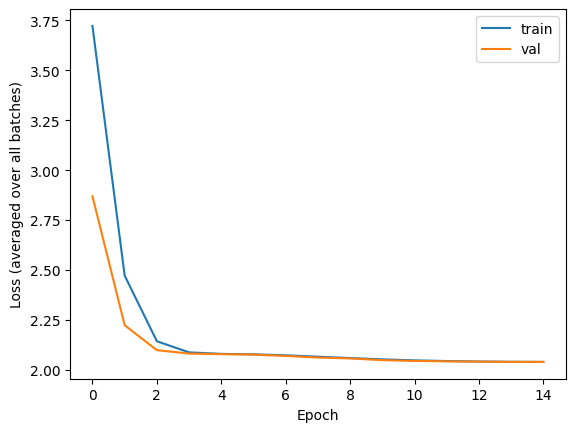

In [98]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss (averaged over all batches)')
plt.show()

In [42]:
def contains_nan(tensor):
    return torch.isnan(tensor).any()


def check_dataloader_for_nan(dataloader):
    for batch_idx, batch in enumerate(dataloader):
        if isinstance(batch, (tuple, list)):  # If batch is a tuple or list (e.g., data, label)
            for i, item in enumerate(batch):
                if isinstance(item, torch.Tensor) and contains_nan(item):
                    print(f"NaN found in batch {batch_idx}, item {i}")
                    return True
        elif isinstance(batch, torch.Tensor):  # If batch itself is a tensor
            if contains_nan(batch):
                print(f"NaN found in batch {batch_idx}")
                return True
    print("No NaNs found in the DataLoader.")
    return False

In [43]:
check_dataloader_for_nan(train_dataloader)

No NaNs found in the DataLoader.


False

In [44]:
check_dataloader_for_nan(val_dataloader)

No NaNs found in the DataLoader.


False

In [45]:
check_dataloader_for_nan(test_dataloader)

KeyboardInterrupt: 